In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata = ad.read_h5ad('./vt_22.04_annotated.h5ad') 

In [3]:
adata = adata[adata.obs['cell_type'].isin(['CTB','STB','EVT'])]
adata

View of AnnData object with n_obs × n_vars = 6593 × 22999
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'cell_type', 'unique_cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Sample_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'scrublet', 'umap', 'unique_cell_type_colors', 'wilcoxon'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'matrix

In [4]:
mitocarta = pd.read_csv("./MitoCarta_full_transformed.csv")

In [5]:
# Create a dictionary where each gene maps to a list of pathways
gene_to_pathway_dict = mitocarta.groupby('Gene')['MitoPathway'].apply(list).to_dict()

In [6]:
# Add pathway information to the var metadata (now allows multiple pathways per gene)
adata.var['MitoPathways'] = adata.var_names.map(lambda x: gene_to_pathway_dict.get(x.split('.')[0], []))
# Check the result
adata.var[['MitoPathways']].head()

/tmp/ipykernel_63046/3510228505.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['MitoPathways'] = adata.var_names.map(lambda x: gene_to_pathway_dict.get(x.split('.')[0], []))


,MitoPathways
Gene,
AC145212.1,[]
MAFIP,[]
AC011043.1,[]
AL592183.1,[]
AC240274.1,[]


In [7]:
# 1. Define pathway names (matching the labels in MitoPathways)
pathway_names = ["OXPHOS", "OXPHOS_subunits", "OXPHOS_assembly_factors", "Complex_I", "CI_subunits", "CI_assembly_factors", 
                 "Complex_II", "CII_subunits", "CII_assembly_factors",
                 "Complex_III", "CIII_subunits", "CIII_assembly_factors",
                 "Complex_IV", "CIV_subunits", "CIV_assembly_factors",
                 "Complex_V", "CV_subunits", "CV_assembly_factors",
                 "Respirasome_assembly", "Cytochrome_C"]

In [8]:
# 2. Extract genes for each pathway
## create a dictionary where each key is a pathway name and each value is a list of genes associated with that pathway 
## finds genes in adata with the 'MitoPathways' annotation
pathway_genes = {}
for pathway in pathway_names:
    pathway_genes[pathway] = adata.var[adata.var['MitoPathways'].apply(lambda x: pathway in x)].index.tolist()
    print(f"Found {len(pathway_genes[pathway])} genes for {pathway}")

Found 156 genes for OXPHOS
Found 89 genes for OXPHOS_subunits
Found 68 genes for OXPHOS_assembly_factors
Found 59 genes for Complex_I
Found 37 genes for CI_subunits
Found 22 genes for CI_assembly_factors
Found 8 genes for Complex_II
Found 4 genes for CII_subunits
Found 4 genes for CII_assembly_factors
Found 15 genes for Complex_III
Found 9 genes for CIII_subunits
Found 6 genes for CIII_assembly_factors
Found 48 genes for Complex_IV
Found 18 genes for CIV_subunits
Found 30 genes for CIV_assembly_factors
Found 24 genes for Complex_V
Found 19 genes for CV_subunits
Found 5 genes for CV_assembly_factors
Found 4 genes for Respirasome_assembly
Found 2 genes for Cytochrome_C


In [9]:
# 3. Calculate the average expression per pathway per unique cell type
## extract list of unique_cell_types
unique_cell_types = adata.obs['unique_cell_type'].cat.categories.tolist()
## create empty df where rows are pathways and columns are cell types to store average expression scores 
pathway_scores = pd.DataFrame(index=pathway_names, columns=unique_cell_types)

In [10]:
# loop through each pathway and its genes; prints warning if no genes found for a pathway
for pathway, genes in pathway_genes.items():
    if not genes:
        print(f"Warning: No genes found for pathway {pathway}")
        continue
        
    # create boolean mask for each cell type, then calculate mean expression of all pathway genes across the cells
    ## stored in pathway_scores df; converted to float
    for cell_type in unique_cell_types:
        cells_mask = adata.obs['unique_cell_type'] == cell_type
        pathway_expr = adata[cells_mask, genes].X.mean(axis=0)
          # Convert to a numeric value explicitly
        pathway_scores.loc[pathway, cell_type] = float(np.mean(pathway_expr))

# Convert the DataFrame to numeric values
pathway_scores = pathway_scores.astype(float)

In [11]:
# 4. calculate Z-score 
## subtract pathway_scores by mean, and divide by standard deviation
## standardises data so each pathway has mean=0 and SD=1
means = pathway_scores.mean(axis=1)
stds = pathway_scores.std(axis=1)
pathway_scores_zscore = pathway_scores.subtract(means, axis=0).divide(stds, axis=0)

In [17]:
# modify labels 
pathway_scores_zscore_display = pathway_scores_zscore.copy()
pathway_scores_zscore_display.columns = pathway_scores_zscore_display.columns.str.replace('_', ' ')
pathway_scores_zscore_display.index = pathway_scores_zscore_display.index.str.replace('_', ' ')

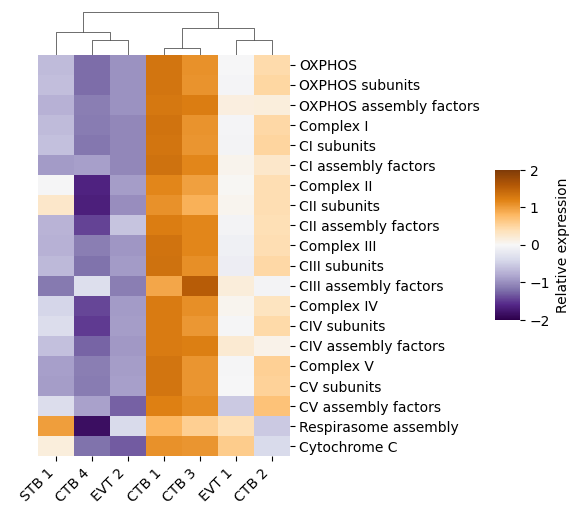

In [18]:
ax = sns.clustermap(pathway_scores_zscore_display, 
                    cmap='PuOr_r',
                    center=0,
                    vmin=-2, vmax=2,
                    figsize=(5, 5),
                    cbar_kws={'label': 'Relative expression'},
                    cbar_pos=(1, 0.35, .05, .3),
                    dendrogram_ratio=0.1,
                    row_cluster=False,
                    col_cluster=True)

# Rotate the x-axis (column) labels
_ = plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Save the figure
ax.savefig("sc1_OXPHOSheatmap.png", dpi=300, bbox_inches='tight')